<div style="border:solid black 2px; padding: 20px"><h1 style="color:black; margin-bottom:20px">Reviewer's comment v1</h1>
Halo Teguh !

Perkenalkan saya disini sebagai Code Reviewers, disini dengan senang hati saya akan mereview tugas Teguh ya.

Saya akan memberikan beberapa komen seperti dibawah ini, tolong jangan dipindah, dirubah, maupun dihapus ya.

Komen yang saya berikan akan muncul dalam warna hijau, kuning, atau pun merah seperti ini:

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

<div class="alert alert-warning">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Terdapat beberapa catatan.

</div>

<div class="alert alert-danger">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Perlu beberapa perbaikan

</div>

Dan tentu saja Teguh dapat menjawab saya dengan menggunakan ini

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>
    
Baik kak
</div>

Rusty Bargain adalah perusahaan jual beli mobil bekas yang sedang mengembangkan sebuah aplikasi untuk menarik pembeli baru. Dalam aplikasi tersebut, kamu bisa dengan cepat mengetahui nilai pasar mobilmu. Kamu memiliki akses ke data historis, spesifikasi teknis kendaraan, versi model kendaraan, dan harga kendaraan. Tugasmu adalah membuat suatu model yang mampu menentukan nilai pasar mobil.
Rusty Bargain tertarik pada:

- kualitas prediksi;
- kecepatan model dalam memprediksi;
- waktu yang diperlukan untuk melatih model

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

## Persiapan Data

### Mengimport Library

In [1]:
import pandas as pd
import numpy as np
import random as rand
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy.stats import randint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

**Library Fungsi**


In [2]:
# fungsi untuk laporan missing value
def missing_report(data):
    report = data.isna().sum().to_frame(name='count')
    report['percentage'] = (report['count'] / len(data) * 100).round(2).astype('str')+'%'
    return report

# fungsi untuk menghapus outlier
def remove_outlier(data, col):
    Q1 = data[col].quantile(.25)
    Q3 = data[col].quantile(.75)
    IQR = Q3 - Q1
    #
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR
    #
    data = data[(data[col] >= lower_whisker) & (data[col] <= upper_whisker)]
    return data

### Memuat dan Pemahaman Data

In [3]:
# memuat data
df = pd.read_csv('/datasets/car_data.csv')

In [4]:
# menampilkan informasi umum dari data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Nama-nama kolom pada dataset sepertinya perlu dirubah.

In [5]:
# statistika deskriptif data
display(df.describe().transpose(),
       df.describe(include='object').transpose())

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Mileage,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


,count,unique,top,freq
DateCrawled,354369,15470,05/03/2016 14:25,66
VehicleType,316879,8,sedan,91457
Gearbox,334536,2,manual,268251
Model,334664,250,golf,29232
FuelType,321474,7,petrol,216352
Brand,354369,40,volkswagen,77013
NotRepaired,283215,2,no,247161
DateCreated,354369,109,03/04/2016 00:00,13719
LastSeen,354369,18592,07/04/2016 07:16,654


In [6]:
# ukuran dataset
df.shape

(354369, 16)

In [7]:
# memeriksa duplikat
df.duplicated().sum()

262

In [8]:
# menghapus duplikat
df.drop_duplicates(inplace=True)

In [9]:
# menghitung missing value
missing_report(df)

,count,percentage
DateCrawled,0,0.0%
Price,0,0.0%
VehicleType,37484,10.59%
RegistrationYear,0,0.0%
Gearbox,19830,5.6%
Power,0,0.0%
Model,19701,5.56%
Mileage,0,0.0%
RegistrationMonth,0,0.0%
FuelType,32889,9.29%


In [10]:
# menampilkan 5 baris pertama
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


**Insight**

1. Dataset ini memiliki `354.369` baris observasi dan `16` kolom, lalu kita menjumpai *missing value* pada beberapa kolom yang persentasenya terbilang cukup besar. 
2. Dari ke-16 kolom kita akan menghapus beberapa kolom yang tidak relevan. Untuk nama-nama kolomnya yaitu:
    - `DateCrawled`
    - `RegistrationMonth`
    - `DateCreated`
    - `NumberOfPictures`
    - `PostalCode`
    - `LastSeen`
    - `model`
    
3. Untuk kolom `Price`,`RegistrationYear` dan `Power` kita menemukan nilai yang tidak mungkin atau mustahil, dimana harga dari kendaraan bernilai `0` dan terdaftar kendaraan dimulai dari tahun `1000` dan berakhir di tahun `9999`. Pada tahap selanjutnya nilai pada kedua kolom tersebut akan kita atasi.

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

### Memperbaiki Kualitas Data

In [11]:
# menghapus kolom yang tidak relevan
df = df.drop(['DateCrawled','RegistrationMonth','DateCreated'\
              ,'NumberOfPictures','PostalCode','LastSeen'], axis=1)

In [12]:
# mengganti nama kolom
df.columns = ['price','vehicle_type','registration_year','gearbox'\
              ,'power','model','mileage','fuel_type','brand','not_repaired']

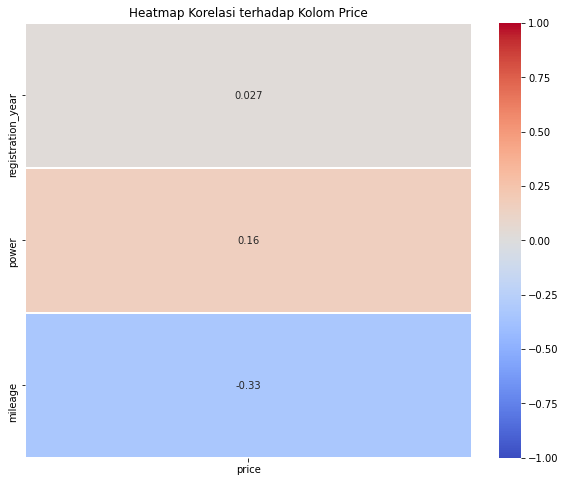

In [13]:
corr = df.corr()['price']

# Membuat DataFrame baru yang berisi korelasi terhadap kolom 'price'
corr_df = df.corr()['price'].drop('price')  # Menghapus korelasi kolom 'price' terhadap dirinya sendiri


# Menghitung korelasi antar kolom dan membuat heatmap
plt.figure(figsize=(10, 8))
a = sns.color_palette("mako", as_cmap=True)

sns.heatmap(corr_df.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Heatmap Korelasi terhadap Kolom Price')
plt.show()

#### `registration_year`

In [14]:
# memeriksa nilai minimum dan maksimum dari registration_year
df.registration_year.min(), df.registration_year.max() 

(1000, 9999)

Kita akan melakukan pembersihan data pada dataset dengan fokus pada rentang tahun yang masuk akal dengan memfilter data menggunakan batas rentang interquartile.

In [15]:
# menerapkan fungsi
df = remove_outlier(df, 'registration_year')

In [16]:
# memeriksa kembali nilai minimum dan maksimum dari registration_year
df.registration_year.min(), df.registration_year.max() 

(1986, 2019)

#### `price`

Dalam jual beli khususnya dalam penjualan mobil, sangat tidak mungkin jika terdapat harga kendaraan tersebut senilai `0` euro. Untuk itu kita akan menentukan batas minimum untuk kolom `price` adalah `100` euro. 

kita tidak akan menghapus data menggunakan batas interquartile karena variabel ini merupakan termasuk variabel response (dependen)

In [17]:
# memfilter dataset dengan price diatas 100
df = df.query('price > 100')

#### `power`

Untuk kolom power kita akan melakukan hal yang sama seperti kolom `registration_year`.

In [18]:
# nilai min dan max pada kolom power
df.power.min(), df.power.max()

(0, 20000)

In [19]:
# menghapus outlier dengan memanggil fungsi
df = remove_outlier(df, 'power')

In [20]:
# nilai min dan max sesudahnya
df.power.min(), df.power.max()

(0, 251)

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

### Mengatasi *Missing Value*

Sebelumnya kita mendapati terdapat 5 kolom yang mengandung *missing value*, berikut untuk nama-nama kolom tersebut:
- `vehicle_type`
- `gearbox`
- `model`
- `fuel_type`
- `not_repaired`

In [21]:
# mengatur ukuran tabel
pd.set_option('display.max_colwidth', 1)

columns_to_check = ['vehicle_type','gearbox','model','fuel_type','not_repaired']

# list untuk menampung item
list_item = []

for col in columns_to_check:
    list_item.append([col, df[col].nunique(), df[col].unique(), len(df[col])])
    
# membuat tabel unique
unique_table_info = pd.DataFrame(list_item, columns=['columns', 'number_unique', 'unique_value', 'length'])
# menampilkan tabel unique
unique_table_info

,columns,number_unique,unique_value,length
0,vehicle_type,8,"[nan, coupe, suv, small, sedan, convertible, bus, wagon, other]",327163
1,gearbox,2,"[manual, auto, nan]",327163
2,model,247,"[golf, nan, grand, fabia, 3er, 2_reihe, c_max, 3_reihe, passat, navara, polo, twingo, a_klasse, scirocco, 5er, meriva, arosa, other, c4, civic, punto, e_klasse, clio, kadett, kangoo, one, fortwo, 1er, b_klasse, signum, astra, a8, jetta, fiesta, c_klasse, micra, vito, sprinter, 156, escort, forester, xc_reihe, scenic, a4, ka, a1, insignia, transporter, combo, focus, tt, corsa, a6, jazz, omega, slk, 80, 147, z_reihe, sportage, sorento, v40, ibiza, eos, touran, getz, a3, almera, megane, 7er, lupo, r19, zafira, mondeo, cordoba, colt, impreza, vectra, berlingo, tiguan, i_reihe, mustang, espace, sharan, 6_reihe, panda, up, seicento, ceed, 5_reihe, yeti, octavia, mii, rx_reihe, modus, fox, matiz, beetle, c1, rio, ...]",327163
3,fuel_type,7,"[petrol, gasoline, nan, lpg, other, hybrid, cng, electric]",327163
4,not_repaired,2,"[nan, yes, no]",327163


Kita akan mengisi nilai yang hilang dengan nilai `unknown` karena ini memungkinkan model untuk memperlakukan *missing value* sebagai kategori yang terpisah dan biasanya lebih aman karena tidak memengaruhi statistik dasar.

In [22]:
# mengisi missing value dengan unknown
df[columns_to_check] = df[columns_to_check].fillna('unknown')

### Memeriksa Final Dataset

In [23]:
# memeriksa missing value
missing_report(df)

,count,percentage
price,0,0.0%
vehicle_type,0,0.0%
registration_year,0,0.0%
gearbox,0,0.0%
power,0,0.0%
model,0,0.0%
mileage,0,0.0%
fuel_type,0,0.0%
brand,0,0.0%
not_repaired,0,0.0%


In [24]:
# memeriksa duplikat
df.duplicated().sum()

41817

In [25]:
# menghapus duplikat
df.drop_duplicates(inplace=True)

In [26]:
# deskriptif umum dataset
display(df.describe().transpose(),
        df.describe(include='object').transpose())

,count,mean,std,min,25%,50%,75%,max
price,285346.0,4500.424786,4426.137004,101.0,1200.0,2860.0,6490.0,20000.0
registration_year,285346.0,2003.781623,6.435535,1986.0,1999.0,2003.0,2008.0,2019.0
power,285346.0,104.762699,55.984439,0.0,71.0,105.0,140.0,251.0
mileage,285346.0,127930.740224,37425.474035,5000.0,125000.0,150000.0,150000.0,150000.0


,count,unique,top,freq
vehicle_type,285346,9,sedan,71745
gearbox,285346,3,manual,219939
model,285346,248,golf,22254
fuel_type,285346,8,petrol,172799
brand,285346,40,volkswagen,59652
not_repaired,285346,3,no,199697


In [27]:
df.sample(5)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
256653,1400,unknown,2018,manual,0,scenic,150000,petrol,renault,no
145589,7700,wagon,2005,manual,147,avensis,40000,petrol,toyota,no
241110,11699,suv,2008,auto,239,touareg,150000,gasoline,volkswagen,unknown
102924,13000,sedan,2009,auto,160,insignia,125000,gasoline,opel,no
314243,1500,wagon,1995,manual,0,unknown,150000,unknown,audi,no


In [28]:
# ukuran dataset final
df.shape

(285346, 10)

Dataset final yang didapatkan setelah melalui proses manipulasi data, yaitu sebanyak `263.043` baris dan `10` kolom.

#### Memeriksa Outlier Pada Dataset

In [29]:
numeric_cols = df.describe().columns
# mencari nilai lower dan upper limit pada masing-masing kolom numerikal
list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []
percentage_outlier = []

for feature in numeric_cols: 
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    lower_limit = df[feature].quantile(0.25) - 1.5*IQR
    upper_limit = df[feature].quantile(0.75) + 1.5*IQR
    
    list_lower.append(lower_limit)
    list_upper.append(upper_limit)
    number_lower.append(len(df[df[feature]<lower_limit])) # menghitung jumlah data yang diluar batas bawah
    number_inside.append(len(df[(df[feature]>=lower_limit) & (df[feature]<=upper_limit)])) # data yg berada didalam rentang kuartil
    number_upper.append(len(df[df[feature]>upper_limit])) # jumlah data yang diluar batas atas
    percentage_outlier.append(round((len(df[df[feature]<lower_limit]) + len(df[df[feature]>upper_limit])) / len(df)  *100, 2))

# membuat dataset untuk menampilkan jumlah dan persentase data outlier
outliers = pd.DataFrame({
    'columns' : numeric_cols,
    'lower_whisker' : list_lower,
    'upper_whisker' : list_upper,
    'count_outside_lower' : number_lower,
    'count_inside' : number_inside,
    'count_outside_upper' : number_upper,
    'percent_outlier' : percentage_outlier
})

outliers['percent_outlier'] = outliers['percent_outlier'].astype('str') +'%'
outliers

,columns,lower_whisker,upper_whisker,count_outside_lower,count_inside,count_outside_upper,percent_outlier
0,price,-6735.0,14425.0,0,270620,14726,5.16%
1,registration_year,1985.5,2021.5,0,285346,0,0.0%
2,power,-32.5,243.5,0,284352,994,0.35%
3,mileage,87500.0,187500.0,43650,241696,0,15.3%


#### Korelasi Kolom Numerikal Terhadap Target

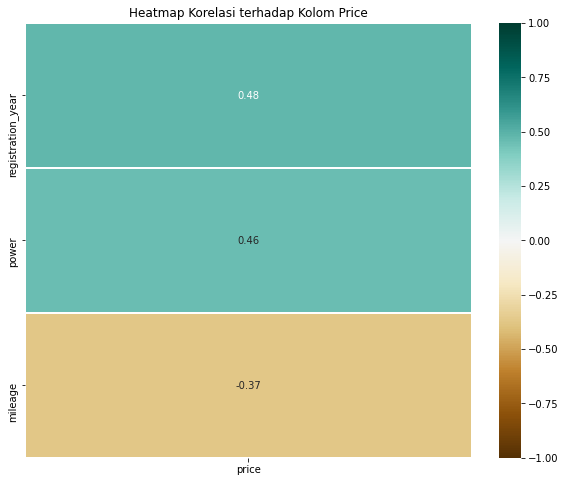

In [30]:
corr = df.corr()['price']

# Membuat DataFrame baru yang berisi korelasi terhadap kolom 'price'
corr_df = df.corr()['price'].drop('price')  # Menghapus korelasi kolom 'price' terhadap dirinya sendiri


# Menghitung korelasi antar kolom dan membuat heatmap
plt.figure(figsize=(10, 8))
a = sns.color_palette("mako", as_cmap=True)

sns.heatmap(corr_df.to_frame(), annot=True, cmap='BrBG', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Heatmap Korelasi terhadap Kolom Price')
plt.show()

#### Distribusi Data Kategorik

In [31]:
# mengatur ukuran tabel
pd.set_option('display.max_colwidth', 1)

# list untuk menampung item
list_item = []

for col in df.describe(include='object').columns:
    list_item.append([col, df[col].nunique(), df[col].unique(), len(df[col])])
    
# membuat tabel unique
unique_table_info = pd.DataFrame(list_item, columns=['columns', 'number_unique', 'unique_value', 'length'])
# menampilkan tabel unique
unique_table_info

,columns,number_unique,unique_value,length
0,vehicle_type,9,"[unknown, coupe, suv, small, sedan, convertible, bus, wagon, other]",285346
1,gearbox,3,"[manual, auto, unknown]",285346
2,model,248,"[golf, unknown, grand, fabia, 3er, 2_reihe, c_max, 3_reihe, passat, navara, polo, twingo, a_klasse, scirocco, 5er, meriva, arosa, other, c4, civic, punto, e_klasse, clio, kadett, kangoo, one, fortwo, 1er, b_klasse, signum, astra, a8, jetta, fiesta, c_klasse, micra, vito, sprinter, 156, escort, forester, xc_reihe, scenic, a4, ka, a1, insignia, transporter, combo, focus, tt, corsa, a6, jazz, omega, slk, 80, 147, z_reihe, sportage, sorento, v40, ibiza, eos, touran, getz, a3, almera, megane, 7er, lupo, r19, zafira, mondeo, cordoba, colt, impreza, vectra, berlingo, tiguan, i_reihe, mustang, espace, sharan, 6_reihe, panda, up, seicento, ceed, 5_reihe, yeti, octavia, mii, rx_reihe, modus, fox, matiz, beetle, c1, rio, ...]",285346
3,fuel_type,8,"[petrol, gasoline, unknown, lpg, other, hybrid, cng, electric]",285346
4,brand,40,"[volkswagen, audi, jeep, skoda, bmw, peugeot, ford, mazda, nissan, renault, mercedes_benz, opel, seat, citroen, honda, fiat, mini, smart, hyundai, alfa_romeo, subaru, volvo, mitsubishi, kia, lancia, sonstige_autos, toyota, chevrolet, dacia, suzuki, daihatsu, chrysler, jaguar, daewoo, rover, porsche, saab, land_rover, trabant, lada]",285346
5,not_repaired,3,"[unknown, yes, no]",285346


**Insight**

Kita masih mendapati outlier pada data namun untuk korelasi kolom numerik terhadap target telah meningkat dan untuk kolom kategorik kita mendapati bahwa kolom-kolom tersebut semuanya merupakan data nominal dimana artinya tidak terdapat urutan atau tingkatan tertentu dalam data. Untuk itu kita akan melakukan transformasi untuk penskalaan menggunakan *RobustScaler* dan untuk data kategorik kita menggunakan *One-hot-Encoding* dan membuat kolom `model` dan `brand` karena dengan menggukana *OHE* dengan banyak nilai unique pada kolom kategorikal kita akan memiliki terlalu banyak dimensi data.

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

## Pelatihan Model

Poin utama dari langkah ini adalah untuk membandingkan metode-metode gradient boosting dengan random forest, decision tree, dan regresi linear. Beberapa model dapat menangani fitur kategorikal, sementara yang lain tidak bisa. Oleh karena itu, kita perlu menyiapkan dua features terpisah untuk kebutuhan pelatihan dari model-model ini.

### Membagi Feature dan Target

In [32]:
# features
features = df.drop(['price','model','brand'], axis=1)
# features ohe
features_ohe = pd.get_dummies(features, drop_first=True)
# target
target = df.price

Kemudian lakukan penskalaan data

In [33]:
# definisikan scaler
scaler = RobustScaler()

In [34]:
#
numeric_cols = features.describe().columns
# features untuk LightGBM dan CatBoost 
transformer_mas = scaler.fit(features[numeric_cols].to_numpy())
features.loc[:, numeric_cols] = transformer_mas.transform(features[numeric_cols].to_numpy())
features.sample(5)

,vehicle_type,registration_year,gearbox,power,mileage,fuel_type,not_repaired
219604,coupe,-0.777778,manual,0.942029,0.0,petrol,no
224859,sedan,0.111111,manual,0.159420,-1.0,petrol,no
10492,coupe,0.111111,auto,1.376812,0.0,petrol,no
190877,unknown,-1.444444,manual,-0.768116,0.0,petrol,unknown
289763,convertible,0.444444,manual,0.304348,-1.0,petrol,no


In [35]:
# features untuk algoritma lainnya
features_ohe = scaler.fit_transform(features_ohe)
features_ohe

array([[-1.11111111, -1.52173913,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.88888889,  1.23188406, -1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.11111111,  0.84057971, -1.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.33333333, -0.05797101, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.77777778, -0.04347826,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11111111, -0.07246377,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

### Default Parameter

In [36]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(), ['vehicle_type','gearbox','fuel_type','not_repaired']),
    ('ordinal', OrdinalEncoder(), ['brand']),
])

In [37]:
def rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

#
rmse_scorer = make_scorer(rmse)

In [38]:
def eval_model(model, features, target):
        
    # Inisialisasi list untuk menyimpan hasil
    model_names = []
    rmse_scores = []
    execution_time = []  # Menyimpan waktu eksekusi

    # splitting data
    features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                                target, 
                                                                                test_size=.4, 
                                                                                random_state=45)
    #
    start_time = time.time()  # Waktu mulai eksekusi

    name = model.__class__.__name__
    #
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    rmse_score = rmse(target_test, target_pred)

    end_time = time.time()  # Waktu akhir eksekusi
    exec_time = end_time - start_time  # Menghitung waktu eksekusi

    model_names.append(name)
    rmse_scores.append(rmse_score)
    execution_time.append(exec_time)
    #
    
    data_result = pd.DataFrame({
        'Algoritma' : model_names,
        'RMSE Score' : rmse_scores,
        'Execution Time (s)' : execution_time
    })
    return data_result

#### Linear Regression

Regresi linear memang tidak terlalu cocok untuk mengatur hyperparameter, tetapi regresi linear merupakan model yang tepat untuk melakukan sanity check dibandingkan metode lainnya. Jika kinerja gradient boosting tidak lebih baik daripada regresi linear, berarti ada sesuatu yang salah.

In [39]:
lr = LinearRegression()

In [40]:
default_result_lr = eval_model(lr, features_ohe, target)
default_result_lr

,Algoritma,RMSE Score,Execution Time (s)
0,LinearRegression,2756.19299,0.299623


#### Random Forest 

In [41]:
rf = RandomForestRegressor(random_state=45)

In [42]:
default_result_rf = eval_model(rf, features_ohe, target)
default_result_rf

,Algoritma,RMSE Score,Execution Time (s)
0,RandomForestRegressor,1861.746372,55.937407


#### Decision Tree

In [43]:
dt = DecisionTreeRegressor(random_state=45)

In [44]:
default_result_dt = eval_model(dt, features_ohe, target)
default_result_dt

,Algoritma,RMSE Score,Execution Time (s)
0,DecisionTreeRegressor,2145.443697,0.891695


#### K-Nearest Neighbors

In [45]:
knn = KNeighborsRegressor()

In [46]:
default_result_knn = eval_model(knn, features_ohe, target)
default_result_knn

,Algoritma,RMSE Score,Execution Time (s)
0,KNeighborsRegressor,1995.676664,678.248446


#### CatBoost

In [50]:
cat_features = features.describe(include='object').columns.to_list()
cat_features

['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']

In [51]:
catboostreg = CatBoostRegressor(cat_features=cat_features, verbose=70)

In [52]:
default_result_cbr = eval_model(catboostreg, features, target)
default_result_cbr

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.092273
0:	learn: 4161.1389238	total: 305ms	remaining: 5m 4s
70:	learn: 1940.9245228	total: 16.8s	remaining: 3m 40s
140:	learn: 1891.2517878	total: 31.9s	remaining: 3m 14s
210:	learn: 1867.6192197	total: 46.7s	remaining: 2m 54s
280:	learn: 1844.5742795	total: 1m 2s	remaining: 2m 40s
350:	learn: 1830.5676276	total: 1m 18s	remaining: 2m 24s
420:	learn: 1817.2838688	total: 1m 34s	remaining: 2m 9s
490:	learn: 1805.2234345	total: 1m 49s	remaining: 1m 53s
560:	learn: 1795.0473753	total: 2m 4s	remaining: 1m 37s
630:	learn: 1786.7652789	total: 2m 20s	remaining: 1m 22s
700:	learn: 1780.2756685	total: 2m 35s	remaining: 1m 6s
770:	learn: 1773.0377252	total: 2m 51s	remaining: 51s
840:	learn: 1766.6234193	total: 3m 7s	remaining: 35.5s
910:	learn: 1761.5178569	total: 3m 23s	remaining: 19.8s
980:	learn: 1755.7073087	total: 3m 39s	remaining: 4.25s
999:	learn: 1754.3084194	total: 3m 43s	remaining: 0us


,Algoritma,RMSE Score,Execution Time (s)
0,CatBoostRegressor,1804.695271,225.190451


#### LightGBM

In [53]:
lgbmreg = LGBMRegressor()

In [54]:
default_result_lgbm = eval_model(lgbmreg, features_ohe, target)
default_result_lgbm

,Algoritma,RMSE Score,Execution Time (s)
0,LGBMRegressor,1852.264828,3.294449


#### XGBoost

In [55]:
xgbreg = XGBRegressor(random_state=45)

In [56]:
default_result_xgb = eval_model(xgbreg, features_ohe, target)
default_result_xgb

,Algoritma,RMSE Score,Execution Time (s)
0,XGBRegressor,1802.343415,42.045885


#### Perbandingan Model Dengan Default Parameter

In [57]:
# menggabungkan dataset
default_compare = pd.concat([default_result_xgb, default_result_lgbm, default_result_cbr,
                           default_result_knn, default_result_dt, default_result_rf, default_result_lr] , ignore_index=True).sort_values('RMSE Score')

In [58]:
# menampilkan hasilnya
default_compare

,Algoritma,RMSE Score,Execution Time (s)
0,XGBRegressor,1802.343415,42.045885
2,CatBoostRegressor,1804.695271,225.190451
1,LGBMRegressor,1852.264828,3.294449
5,RandomForestRegressor,1861.746372,55.937407
3,KNeighborsRegressor,1995.676664,678.248446
4,DecisionTreeRegressor,2145.443697,0.891695
6,LinearRegression,2756.192990,0.299623


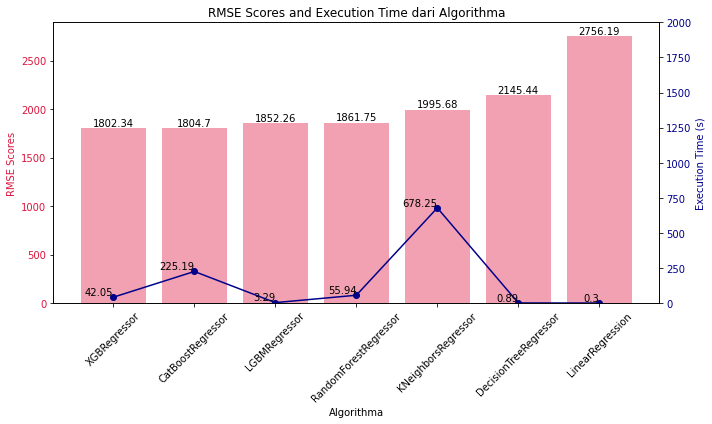

In [59]:
# membuat visualisasi
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot untuk RMSE Scores (sumbu y pertama)
bars = ax1.bar(default_compare['Algoritma'], default_compare['RMSE Score'], color='crimson', alpha=0.4)
ax1.set_xlabel('Algorithma')
ax1.set_ylabel('RMSE Scores', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')
plt.xticks(rotation=45)

# Menambahkan label pada bar plot
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

    
# Menambahkan sumbu y kedua untuk Execution Time (sumbu y kedua)
ax2 = ax1.twinx()
ax2.plot(default_compare['Algoritma'], default_compare['Execution Time (s)'], color='darkblue', marker='o')
ax2.set_ylabel('Execution Time (s)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Menambahkan label pada titik-titik pada line plot
for i, txt in enumerate(default_compare['Execution Time (s)']):
    ax2.text(i, txt, round(txt, 2), ha='right', va='bottom')
    

# Judul dan layout
plt.title('RMSE Scores and Execution Time dari Algorithma')
plt.ylim(0, 2000)
plt.tight_layout()
plt.show()


**Kesimpulan**

Untuk perbandingan model menggunakan default parameter kita mendapatkan RMSE terendah menggunakan XGBoost dan waktu eksekusi yang bisa dibilang cepat. 

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

### Tuning Hyper-Parameter

In [60]:
# scoring untuk rmse
scorer = make_scorer(rmse, greater_is_better=False)

In [61]:
# splitting data untuk features ohe
features_ohe_train, features_ohe_test, target_train, target_test = train_test_split(features_ohe,
                                                                                   target, test_size=.4,
                                                                                   random_state=45)

#### Random Forest

In [62]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 45,
 'verbose': 0,
 'warm_start': False}

In [63]:
%%time
rmse_scores = []
n_est = []
executed_time = []

for est in range(2, 101, 15):
    rf = RandomForestRegressor(n_estimators=est, random_state=45)
    start_time = time.time()
    
    # Calculate cross validation score with RMSE as metric
    rf.fit(features_ohe_train, target_train)
    
    # Calculate the average of the best RMSE scores and scores
    target_pred = rf.predict(features_ohe_test)
    rmse_score = rmse(target_test, target_pred)

    end_time = time.time()  # Waktu akhir eksekusi
    exec_time = end_time - start_time  # Menghitung waktu eksekusi
    
    rmse_scores.append(rmse_score)
    n_est.append(est)
    executed_time.append(exec_time)
        
pd.DataFrame({
    'n_estimators' : n_est,
    'rmse' : rmse_scores,
    'executed_time' : executed_time
}).sort_values('rmse')

CPU times: user 3min 11s, sys: 261 ms, total: 3min 12s
Wall time: 3min 12s


,n_estimators,rmse,executed_time
6,92,1862.052160,51.076864
5,77,1862.913939,43.107810
4,62,1865.155439,35.992705
3,47,1866.944655,30.039186
2,32,1871.589559,20.261524
1,17,1881.919744,10.806509
0,2,2044.506165,1.245737


Kita tidak menemukan nilai yang lbih bagus dari n_estimators = 100. Untuk itu kita akan tetap menggunakan nilai defaultnya. selanjutnya dengan mencoba untuk max_depth.

In [64]:
rmse_scores = []
max_depth = []
executed_time = []

for depth in range(1, 50, 3):
    rf = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=45)
    start_time = time.time()
    
    # Calculate cross validation score with RMSE as metric
    rf.fit(features_ohe_train, target_train)
    
    # Calculate the average of the best RMSE scores and scores
    target_pred = rf.predict(features_ohe_test)
    rmse_score = rmse(target_test, target_pred)

    end_time = time.time()  # Waktu akhir eksekusi
    exec_time = end_time - start_time  # Menghitung waktu eksekusi
    
    rmse_scores.append(rmse_score)
    max_depth.append(depth)
    executed_time.append(exec_time)
        
pd.DataFrame({
    'max_depth' : max_depth,
    'rmse' : rmse_scores,
    'executed_time' : executed_time
}).sort_values('rmse')

,max_depth,rmse,executed_time
5,16,1819.378720,46.881956
6,19,1834.949102,50.527522
4,13,1838.690394,41.540665
7,22,1851.841768,54.321527
8,25,1858.934220,61.920298
10,31,1860.898874,56.122422
9,28,1861.298599,55.140944
11,34,1861.635156,55.919642
12,37,1861.728499,55.632960
14,43,1861.746372,56.316812


Untuk algoritma random forest kita mendapatkan parameter n_estimators = 100 dan max_depth = 16. Akan tetapi waktu eksekusinya cukup lama.

In [65]:
# definisi model dengan best parameter
rf_best_param = RandomForestRegressor(n_estimators=100, max_depth=16, random_state=45)

In [66]:
new_rf_result = eval_model(rf_best_param, features_ohe, target)
new_rf_result

,Algoritma,RMSE Score,Execution Time (s)
0,RandomForestRegressor,1819.37872,46.887318


#### LightGBM

In [67]:
# param lightGBM
lgbmreg.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [68]:
%%time

# Definisi Parameter
param_dist = {
    'n_estimators': np.arange(50, 200, 20),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.5, 10),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'reg_alpha': np.linspace(0.0, 1.0, 10),
    'reg_lambda': np.linspace(0.0, 1.0, 10)
}

# Inisialisasi RandomizedSearchCV
lgbm_random = RandomizedSearchCV(
    estimator=lgbmreg,
    param_distributions=param_dist,
    n_iter=10,  # Jumlah iterasi pencarian acak
    cv=5,  # Jumlah lipatan cross-validation
    scoring=scorer,  # Metrik evaluasi yang digunakan
    random_state=45, n_jobs= -1
)

# Melakukan fitting model ke data
lgbm_random.fit(features_ohe_train, target_train)
best_lgbm = lgbm_random.best_estimator_

# Menampilkan parameter terbaik yang dihasilkan
print("Parameter terbaik:", lgbm_random.best_estimator_)
print("RMSE Score", -1 * lgbm_random.best_score_)

Parameter terbaik: LGBMRegressor(colsample_bytree=0.7777777777777778,
              learning_rate=0.22777777777777777, max_depth=9, n_estimators=150,
              reg_alpha=0.7777777777777777, reg_lambda=0.6666666666666666,
              subsample=0.6666666666666666)
RMSE Score 1807.6072072889733
CPU times: user 2min 56s, sys: 1.12 s, total: 2min 57s
Wall time: 2min 59s


In [69]:
new_lgbm_result = eval_model(best_lgbm, features_ohe, target)
new_lgbm_result

,Algoritma,RMSE Score,Execution Time (s)
0,LGBMRegressor,1803.768249,4.027401


Untuk algoritma LightGBM dengan tuning hyper-param kita mendapatkan peningkatan sebesar 50 point untuk nilai RMSE menjadi 1803.

#### CatBoost

In [70]:
catboostreg.get_params()

{'loss_function': 'RMSE',
 'verbose': 70,
 'cat_features': ['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']}

Karena algoritma ini dapat megatasi langsung feature kategorik, kita akan splitting ulang data.

In [71]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.4,
                                                                           random_state=45)

In [72]:
%%time
# Definisi Parameter
param_dist = {
    'iterations': np.arange(50, 200, 25),
    'depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.5, 10),
    'l2_leaf_reg': np.linspace(0.0, 1.0, 10),
    'border_count': np.arange(5, 255, 10)
}

# Inisialisasi RandomizedSearchCV
catboost_random = RandomizedSearchCV(
    estimator= catboostreg,
    param_distributions= param_dist,
    n_iter= 10,  
    cv= 5,  
    scoring= scorer,  
    random_state= 45, n_jobs = -1
)

# Melakukan fitting model ke data
catboost_random.fit(features_train, target_train)

# Menampilkan parameter terbaik yang dihasilkan
best_catboost = catboost_random.best_estimator_

# Menampilkan parameter terbaik yang dihasilkan
print("Parameter terbaik:", catboost_random.best_estimator_)
print("RMSE Score", -1 * catboost_random.best_score_)

0:	learn: 3246.7999455	total: 99ms	remaining: 17.2s
70:	learn: 1886.9399090	total: 6.23s	remaining: 9.12s
140:	learn: 1856.4379253	total: 12.2s	remaining: 2.95s
174:	learn: 1846.4889642	total: 15.1s	remaining: 0us
0:	learn: 3276.6635744	total: 95.1ms	remaining: 16.5s
70:	learn: 1899.6001174	total: 6.05s	remaining: 8.87s
140:	learn: 1867.7939914	total: 11.9s	remaining: 2.88s
174:	learn: 1857.3688710	total: 14.8s	remaining: 0us
0:	learn: 3247.1069820	total: 93.3ms	remaining: 16.2s
70:	learn: 1893.7406674	total: 6.22s	remaining: 9.11s
140:	learn: 1864.8227432	total: 12.2s	remaining: 2.93s
174:	learn: 1854.9199566	total: 15s	remaining: 0us
0:	learn: 3243.4475054	total: 96ms	remaining: 16.7s
70:	learn: 1887.6369344	total: 6.08s	remaining: 8.9s
140:	learn: 1856.0363260	total: 12s	remaining: 2.89s
174:	learn: 1844.4212626	total: 14.9s	remaining: 0us
0:	learn: 3254.1081119	total: 96ms	remaining: 16.7s
70:	learn: 1896.6631682	total: 6.1s	remaining: 8.94s
140:	learn: 1866.4647227	total: 12s	rema

In [73]:
new_result_cat = eval_model(best_catboost, features, target)
new_result_cat

0:	learn: 3039.1873936	total: 151ms	remaining: 26.2s
70:	learn: 1756.3404596	total: 10.1s	remaining: 14.8s
140:	learn: 1687.0393990	total: 19.9s	remaining: 4.81s
174:	learn: 1665.2793520	total: 24.7s	remaining: 0us


,Algoritma,RMSE Score,Execution Time (s)
0,CatBoostRegressor,1802.186792,25.292798


#### XGBoost

In [74]:
xgbreg.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 45,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [75]:
%%time
# Definisi Parameter
param_dist = {
    'n_estimators': np.arange(50, 200, 25),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.5, 10),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'reg_alpha': np.linspace(0.0, 1.0, 10),
    'reg_lambda': np.linspace(0.0, 1.0, 10)
}

# Inisialisasi RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator= xgbreg,
    param_distributions= param_dist,
    n_iter= 10, 
    cv= 5,
    scoring= scorer,
)

# Melakukan fitting model ke data
xgb_random.fit(features_ohe_train, target_train)
best_xgb = xgb_random.best_estimator_

# Menampilkan parameter terbaik yang dihasilkan
print("Parameter terbaik:", xgb_random.best_estimator_)
print("RMSE Score", -1 * xgb_random.best_score_)

Parameter terbaik: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5555555555555556,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.44555555555555554,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=45,
             reg_alpha=0.0, reg_lambda=0.5555555555555556, scale_pos_weight=1,
             subsample=0.9444444444444444, tree_method='exact',
             validate_parameters=1, verbosity=None)
RMSE Score 1816.0331724741234
CPU times: user 32min 24s, sys: 9.23 s, total: 32min 33s
Wall time: 32min 44s


In [76]:
new_result_xgb = eval_model(best_xgb, features_ohe, target)
new_result_xgb

,Algoritma,RMSE Score,Execution Time (s)
0,XGBRegressor,1809.382324,58.241161


<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

## Analisis Model

In [79]:
# menggabungkan hasil model akhir
final_result = pd.concat([new_lgbm_result,new_rf_result,new_result_cat,new_result_xgb], ignore_index=True).sort_values('RMSE Score')
final_result

,Algoritma,RMSE Score,Execution Time (s)
2,CatBoostRegressor,1802.186792,25.292798
0,LGBMRegressor,1803.768249,4.027401
3,XGBRegressor,1809.382324,58.241161
1,RandomForestRegressor,1819.378720,46.887318


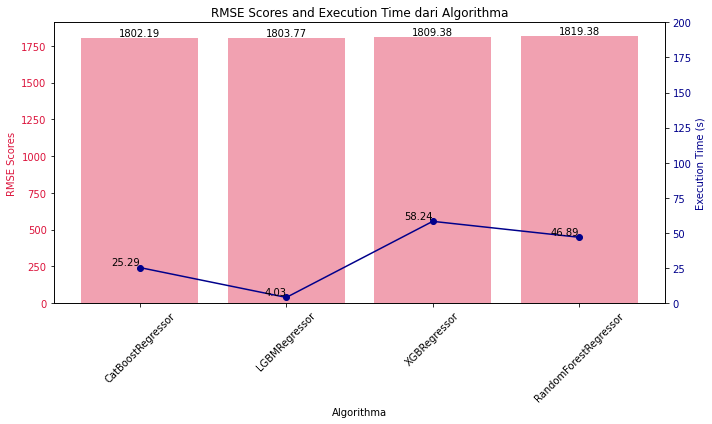

In [83]:
# membuat visualisasi
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot untuk RMSE Scores (sumbu y pertama)
bars = ax1.bar(final_result['Algoritma'], final_result['RMSE Score'], color='crimson', alpha=0.4)
ax1.set_xlabel('Algorithma')
ax1.set_ylabel('RMSE Scores', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')
plt.xticks(rotation=45)

# Menambahkan label pada bar plot
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

    
# Menambahkan sumbu y kedua untuk Execution Time (sumbu y kedua)
ax2 = ax1.twinx()
ax2.plot(final_result['Algoritma'], final_result['Execution Time (s)'], color='darkblue', marker='o')
ax2.set_ylabel('Execution Time (s)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Menambahkan label pada titik-titik pada line plot
for i, txt in enumerate(final_result['Execution Time (s)']):
    ax2.text(i, txt, round(txt, 2), ha='right', va='bottom')
    

# Judul dan layout
plt.title('RMSE Scores and Execution Time dari Algorithma')
plt.ylim(0, 200)
plt.tight_layout()
plt.show()

## Kesimpulan Umum


Adapun tahapan yang dilakukan sebelum modeling adalah:
1. Dataset awal memiliki 354,369 baris dan 16 kolom. Setelah melakukan tahap preprocessing jumlah observasi yang tersisa sebanyak 285,346 baris.
2. Terdapat anomali pada data pada kolom `registration_year`, `price` dan `power`. Lalu dilakukan pembersihan anomali dengan menggunakan batas interquartile untuk kolom `registration_year`dan `power`.
3. Untuk mengatasi *missing value* tahapan yang dilakukan adalah dengan mengisi nilai `unknown`, hal ini bertujuan untuk tidak memengaruhi statistik dasar dari dataset.
4. Saat modeling fitur yang digunakan hanyalah `vehicle_type`, `registration_year`, `gearbox`,`power`, `mileage`, `fuel_type`, `not_repaired`. 

Setelah melakukan modeling untuk algoritma yang menggunakan parameter default kita mendapatkan hasil algoritma terbaik adalah `XGBoost` dengan nilai RMSE terendah dan waktu eksekusi model juga tidak terlalu lama sebesar `44` s. Sedangkan dengan mengatur beberapa hyper parameter kita mendapatkan dua model yang nilai RMSE nya hampir sama akan tetapi untuk waktu eksekusi model yang singkat kita mendapatkan algoritma `LightGBM`. 

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

# Daftar Periksa

Ketik 'x' untuk menandakannya sebagai selesai. Lalu, tekan tombol Shift+Enter

- [x]  Jupyter Notebook bisa dibuka
- [ ]  Tidak ada kesalahan pada kode
- [ ]  Sel-sel dengan kode telah disusun berdasarkan urutan eksekusi
- [ ]  Data telah diunduh dan disiapkan- [ ]  Model sudah dilatih
- [ ]  Analisis terhadap kecepatan dan kualitas model telah dilakukan